# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.


### Описание данных

###### Признаки

    RowNumber — индекс строки в данных
    CustomerId — уникальный идентификатор клиента
    Surname — фамилия
    CreditScore — кредитный рейтинг
    Geography — страна проживания
    Gender — пол
    Age — возраст
    Tenure — сколько лет человек является клиентом банка
    Balance — баланс на счёте
    NumOfProducts — количество продуктов банка, используемых клиентом
    HasCrCard — наличие кредитной карты
    IsActiveMember — активность клиента
    EstimatedSalary — предполагаемая зарплата
    
###### Целевой признак

    Exited — факт ухода клиента

## Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score, roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.utils import shuffle 
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv('/datasets/Churn.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Удалим столбцы. В них нет необходимости для алгоритма

In [ ]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
#data.head(15)

Заменим пропуски в столбце Tenure на 0. Возможно клиент является клиентом банка меньше года. Переведем в целочисленный тип.

In [ ]:
data['Tenure'] = data['Tenure'].fillna(0).astype('int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [ ]:
data.shape

(10000, 11)

###### Подготовим данные методом OHE

In [ ]:
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


In [ ]:
data_ohe.shape

(10000, 12)

###### Делим датасет на выборки: обучающая - 60%, валидационная - 20 %, тестовая - 20 %

In [ ]:
features = data_ohe.drop('Exited', axis=1)
target = data_ohe['Exited']

In [ ]:
features.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1,0


In [ ]:
target.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

In [ ]:
features_train, features_validtest, target_train, target_validtest = train_test_split(features, target,
                                                    train_size=0.6, random_state=12345, stratify=target)

In [ ]:
display(features_train.shape, target_train.shape, features_validtest.shape, target_validtest.shape)

(6000, 11)

(6000,)

(4000, 11)

(4000,)

In [ ]:
features_valid, features_test, target_valid, target_test = train_test_split(features_validtest, target_validtest,
                                                    train_size=0.5, random_state=12345, stratify=target_validtest)

In [ ]:
display(features_valid.shape, target_valid.shape, features_test.shape, target_test.shape)

(2000, 11)

(2000,)

(2000, 11)

(2000,)

###### Масштабируем признаки методом стандартизации

In [ ]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary'] 

In [ ]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

### Вывод:

    ознакомились с данными,
    удалили столбцы (столбцы RowNumber, CustomerId, Surname)
    NaN-значения в столбце Tenure - заменили на 0
    категориальные признаки - столбцы Geography и Gender
    преобразовали категориальные признаки в численные с помощью техники прямого кодирования One-Hot Encoding,
    разбили получившийся датасет на 3 выборки - обучающую, валидационную и тестовую,
    масштабировали признаки методом стандартизации.

## Исследование задачи

Обучим модели и измерим accuracy.

In [ ]:
model = LogisticRegression(random_state=12345,solver = 'liblinear')
model.fit(features_train, target_train)
predicted_valid_lr = pd.Series(model.predict(features_valid))
model.score(features_valid, target_valid)

0.811

In [ ]:
model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=666)
model.fit(features_train, target_train)
predicted_valid_forest = pd.Series(model.predict(features_valid))
model.score(features_valid, target_valid)

0.8635

Доля правильных ответов — 86%.

Чтобы оценить адекватность модели, проверим, как часто в целевом признаке Exited встречается класс «1» или «0».

0    0.7963
1    0.2037
Name: Exited, dtype: float64


<AxesSubplot:>

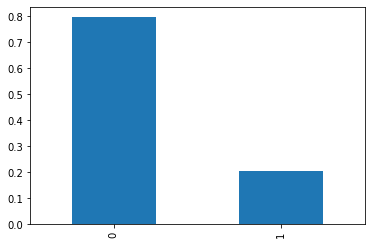

In [ ]:
class_frequency = data['Exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Классы несбалансированы. Клиенты уходят в 20% процентах случаев, т.е. положительный класс меньше отрицательного в 4 раза.

Проанализируем частоты классов в результатах предсказаний обеих моделей

0    0.931
1    0.069
dtype: float64


<AxesSubplot:>

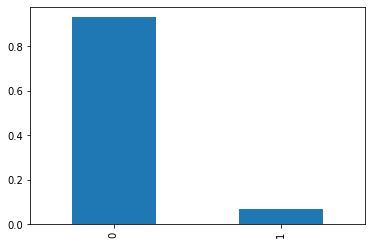

In [ ]:
class_frequency_lr = predicted_valid_lr.value_counts(normalize=True)
print(class_frequency_lr)
class_frequency_lr.plot(kind='bar')

0    0.8845
1    0.1155
dtype: float64


<AxesSubplot:>

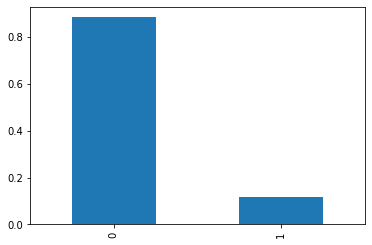

In [ ]:
class_frequency_forest = predicted_valid_forest.value_counts(normalize=True)
print(class_frequency_forest)
class_frequency_forest.plot(kind='bar')

Сравним их работу с константной моделью.

In [ ]:
target_pred_constant = pd.Series(0, target.index)
accuracy_score(target, target_pred_constant)

0.7963

Построенные модели предсказывают уход клиентов лучше, чем константная модель, они адекватны.

Применим F1-меру, чтобы оценить качество прогноза положительного класса у моделей.

In [ ]:
f1_score(target_valid, predicted_valid_lr)

0.3076923076923077

In [ ]:
f1_score(target_valid, predicted_valid_forest)

0.5727699530516431

### Вывод:

    исследовали баланс классов - классы несбалансированы,
    выяснили, что клиенты уходят в 20% процентах случаев, т.е. положительный класс меньше отрицательного в 4 раза,
    изучили модели без учёта дисбаланса
    выяснили, что результат работы модели случайного леса лучше.

## Борьба с дисбалансом

##### 1.Сбалансируем классы с помощью аргумента class_weight.

In [ ]:
model = LogisticRegression(random_state=666, solver = 'liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid_lr = pd.Series(model.predict(features_valid))
f1_score(target_valid, predicted_valid_lr)

0.5302897278314311

In [ ]:
model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=666, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid_forest = pd.Series(model.predict(features_valid))
f1_score(target_valid, predicted_valid_forest)

0.6462212486308871

Мера F1 выглядит намного лучше, у модели LogisticRegression она увеличилась почти в 2 раза.

##### 2.Уменьшение выборки

Сделаем объекты частого класса (0) не такими частыми. Для этого напишем функцию downsample.

In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=666)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=666)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=666)
    
    return features_downsampled, target_downsampled

In [ ]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

In [ ]:
model = LogisticRegression(random_state=666, solver = 'liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid_downsampled_lr = model.predict(features_valid)
f1_score(target_valid, predicted_valid_downsampled_lr)

0.4124597207303974

In [ ]:
model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=666)
model.fit(features_downsampled, target_downsampled)
predicted_valid_downsampled_forest = model.predict(features_valid)
f1_score(target_valid, predicted_valid_downsampled_forest)

0.46650426309378806

Уменьшение выборки дает результаты хуже. Попробуем изменить порог.

##### 3. Изменение порога

In [ ]:
model = LogisticRegression(random_state=666, solver='liblinear')
model.fit(features_train, target_train)
probabilities_valid_lr = model.predict_proba(features_valid)
probabilities_one_valid_lr = probabilities_valid_lr[:, 1]

In [ ]:
#напишем функцию для автоматизации подсчета F1 при разном значении порога
def count_threshold (probabilities_one_valid):
    for threshold in np.arange(0, 0.6, 0.05):
        predicted_valid = probabilities_one_valid > threshold
        f1 = f1_score(target_valid, predicted_valid)
        print("Порог = {:.2f} | F1 = {:.3f}".format(
        threshold, f1))

In [ ]:
count_threshold(probabilities_one_valid_lr)

Порог = 0.00 | F1 = 0.339
Порог = 0.05 | F1 = 0.368
Порог = 0.10 | F1 = 0.427
Порог = 0.15 | F1 = 0.476
Порог = 0.20 | F1 = 0.506
Порог = 0.25 | F1 = 0.519
Порог = 0.30 | F1 = 0.500
Порог = 0.35 | F1 = 0.461
Порог = 0.40 | F1 = 0.429
Порог = 0.45 | F1 = 0.346
Порог = 0.50 | F1 = 0.308
Порог = 0.55 | F1 = 0.277


In [ ]:
model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=666)
model.fit(features_train, target_train)
probabilities_valid_forest = model.predict_proba(features_valid)
probabilities_one_valid_forest = probabilities_valid_forest[:, 1]

In [ ]:
count_threshold(probabilities_one_valid_forest)

Порог = 0.00 | F1 = 0.339
Порог = 0.05 | F1 = 0.380
Порог = 0.10 | F1 = 0.462
Порог = 0.15 | F1 = 0.570
Порог = 0.20 | F1 = 0.621
Порог = 0.25 | F1 = 0.630
Порог = 0.30 | F1 = 0.637
Порог = 0.35 | F1 = 0.639
Порог = 0.40 | F1 = 0.622
Порог = 0.45 | F1 = 0.607
Порог = 0.50 | F1 = 0.573
Порог = 0.55 | F1 = 0.550


Изменение порога показывает результаты лучше, чем уменьшение выборки.

Для модели RandomForestClassifier найдем значения n_estimators и max_depth, при которых она будет показывать лучшие результаты.

In [ ]:
for depth in range(5, 11, 1):
    model = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_train_def = model.predict(features_train)
    predictions_valid_def = model.predict(features_valid)
    print("F1 при max_depth =", depth)
    print("Обучающая выборка:", f1_score(target_train, predictions_train_def))
    print("Валидационная выборка:", f1_score(target_valid, predictions_valid_def))
    print()

F1 при max_depth = 5
Обучающая выборка: 0.545052515201769
Валидационная выборка: 0.560126582278481

F1 при max_depth = 6
Обучающая выборка: 0.5477131564088086
Валидационная выборка: 0.5270049099836335

F1 при max_depth = 7
Обучающая выборка: 0.5846488840500816
Валидационная выборка: 0.5700934579439253

F1 при max_depth = 8
Обучающая выборка: 0.6211312700106724
Валидационная выборка: 0.5829457364341084

F1 при max_depth = 9
Обучающая выборка: 0.6589595375722543
Валидационная выборка: 0.6024464831804281

F1 при max_depth = 10
Обучающая выборка: 0.7039507439712673
Валидационная выборка: 0.6024096385542168



In [ ]:
for estim in range(40, 140, 20):
    model = RandomForestClassifier(random_state=12345, n_estimators=estim, max_depth = 10)
    model.fit(features_train, target_train)
    predictions_train_def2 = model.predict(features_train)
    predictions_valid_def2 = model.predict(features_valid)
    print("F1 при n_estimators =", estim)
    print("Обучающая выборка:", f1_score(target_train, predictions_train_def2))
    print("Валидационная выборка:", f1_score(target_valid, predictions_valid_def2))
    print()

F1 при n_estimators = 40
Обучающая выборка: 0.7000000000000002
Валидационная выборка: 0.598159509202454

F1 при n_estimators = 60
Обучающая выборка: 0.7018984094407389
Валидационная выборка: 0.5828220858895705

F1 при n_estimators = 80
Обучающая выборка: 0.697530864197531
Валидационная выборка: 0.5898617511520737

F1 при n_estimators = 100
Обучающая выборка: 0.6972193614830072
Валидационная выборка: 0.5898617511520737

F1 при n_estimators = 120
Обучающая выборка: 0.6991786447638604
Валидационная выборка: 0.5815384615384616



### Вывод:

    лучшие результаты показал способы борьбы с дисбалансом class_weight, применим его
    работать дальше будем с моделью RandomForestClassifier со значением n_estimators = 40 и max_depth = 9

## Тестирование модели

Обучим финальную модель и проверим её на тестовой выборке.

In [ ]:
#model_final = RandomForestClassifier(random_state=12345, n_estimators=60, max_depth = 10, class_weight='balanced')
#model_final.fit(features_train, target_train)
#predicted_test = model_final.predict(features_test)
#f1_score(target_test, predicted_test)

Нужное значение F1-меры достигнуто.

In [ ]:
model_final = RandomForestClassifier(random_state=12345, n_estimators=40, max_depth = 9, class_weight='balanced')
model_final.fit(features_train, target_train)
predicted_test = model_final.predict(features_test)
f1_score(target_test, predicted_test)

0.6037296037296038

Посчитаем площадь под ROC-кривой для модели (AUC-ROC), чтобы узнать, насколько сильно ее точность отличается от случайной

In [ ]:
probabilities_valid_final = model_final.predict_proba(features_valid)
probabilities_one_valid_final = probabilities_valid_final[:, 1]
roc_auc_score(target_valid, probabilities_one_valid_final)

0.8677532885013302

### Общий вывод

1. Ознакомились с данными и подготовили их к исследованию (преобразовали категориальные признаки в численные с помощью техники прямого кодирования One-Hot Encoding,разбили получившийся датасет на 3 выборки - обучающую, валидационную и тестовую, масштабировали признаки методом стандартизации).
2. Исследовали баланс классов - они оказались несбалансированы, изучили модели без учёта дисбаланса, выяснили, что результат работы модели случайного леса лучше.
3. Применили 3 способа борбы с дисбалансом - аргумент class_weight, уменьшение выборки и изменение порога. Лучшие результаты показал способы борьбы с дисбалансом class_weight. Выявили лучшие значения n_estimators и max_depth для модели случайного леса.
4. Обучили финальную модель и проверили ее на тестовой выборке. Достигли значения F1 = 0.60. Исследовали метрику AUC-ROC - модель далека от случайной.